In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.latex_helpers import df_to_latex
from utils.fairness_functions import reshape_general_violent_cond_auc_summaries

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


## AUC Fairness 

In this notebook, we check the AUC conditioned on the sensitive attributes of race and gender. 

In [2]:
# read in auc data for prediction problems of interest
auc_data = {}
for time_period in [
                    "six-month", 
                    "two-year"
                    ]:
    
    for problem in ['general', 'violent']:
        problem_path = "broward/FL AUC/" + time_period + "/" + problem
        dircontents = os.listdir()
        if os.path.isdir(problem_path):
            onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        else: 
            continue
        for filename in onlyfiles:
            model_name = filename.split("_")[0]
            if model_name in ['ebm', 'riskslim', 'compas', 'arnold']:
                auc_data["-".join((problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

auc_data.keys()

dict_keys(['general-six-month-arnold', 'general-six-month-compas', 'general-six-month-ebm', 'general-two-year-arnold', 'general-two-year-compas', 'general-two-year-ebm', 'violent-two-year-arnold', 'violent-two-year-compas', 'violent-two-year-ebm'])

## AUC of Arnold NCA and Arnold NVCA

In [132]:
# Arnold NCA corresp to general-two-year-arnold
# Arnold NVCA corresp to violent-two-year-arnold
auc_data['general-two-year-compas'].head()
auc_data['violent-two-year-compas'].head()

,Attribute,Attribute Value,AUC,fold_num
0,race,Caucasian,0.565226,0
1,race,African-American,0.602189,0
2,race,Other,0.675926,0
3,race,Hispanic,0.737500,0
4,sex,male,0.637022,0


In [4]:
models = {'arnold': ['Arnold NCA', 'Arnold NVCA Raw'], 
          'compas': ['COMPAS General', "COMPAS Viol."], 
          'ebm': ['EBM', 'EBM']}

res_dfs = []
for model_name, model_table_labels in models.items():
    viol_auc_name = 'violent-two-year-' + model_name
    res_df = reshape_general_violent_cond_auc_summaries(general_auc=auc_data['general-two-year-' + model_name],
                                                        general_model_name=model_table_labels[0],
                                                        violent_auc=auc_data['violent-two-year-' + model_name],
                                                        violent_model_name=model_table_labels[1]
                                                        )
    res_dfs.append(res_df)
    
auc_summary_table = (pd.concat(res_dfs, axis=0)
                        .rename(columns={"African-American": "Afr-Am.",
                                        "Other": "Other Race",
                                        "Hispanic": "Hisp.",
                                        "Caucasian": "Cauc.",
                                        "female": "Female", 
                                        "male": "Male"}))

# TODO: Round OUTPUT
auc_summary_table = auc_summary_table[["Model", "Label", 
                                       "Afr-Am.", "Cauc.", "Hisp.", "Other Race", "race_range",
                                       "Female", "Male", "sex_range"]]

for column_name in ["Afr-Am.", "Cauc.", "Hisp.", "Other Race", "race_range",
                    "Female", "Male", "sex_range"]:
    
    auc_summary_table[column_name] = auc_summary_table[column_name].apply(lambda x: round(x, 3))
    
auc_summary_table

,Model,Label,Afr-Am.,Cauc.,Hisp.,Other Race,race_range,Female,Male,sex_range
0,Arnold NCA,general\_two\_year,0.586,0.602,0.566,0.641,0.076,0.636,0.594,0.042
1,Arnold NVCA Raw,violent\_two\_year,0.601,0.731,0.756,0.657,0.155,0.710,0.639,0.072
0,COMPAS General,general\_two\_year,0.624,0.645,0.531,0.593,0.114,0.685,0.625,0.061
1,COMPAS Viol.,violent\_two\_year,0.633,0.642,0.574,0.658,0.084,0.618,0.637,0.019
0,EBM,general\_two\_year,0.659,0.655,0.630,0.580,0.079,0.708,0.649,0.059
1,EBM,violent\_two\_year,0.657,0.711,0.765,0.663,0.109,0.683,0.668,0.014


In [5]:
# print as latex
df_to_latex(auc_summary_table)

\begin{array}{l | l | r | r | r | r | r | r | r | r} \hline
    \verb|     Model     | & \verb|      Label       | & \verb|Afr-Am.| & \verb|Cauc.| & \verb|Hisp.| & \verb|Other Race| & \verb|race_range| & \verb|Female| & \verb|Male | & \verb|sex_range| \\ \hline
    \hline
    \verb|Arnold NCA     | & general\_two\_year &   0.586 & 0.602 & 0.566 &      0.641 &      0.076 &  0.636 & 0.594 &     0.042 \\ \hline
    \verb|Arnold NVCA Raw| & violent\_two\_year &   0.601 & 0.731 & 0.756 &      0.657 &      0.155 &  0.710 & 0.639 &     0.072 \\ \hline
    \verb|COMPAS General | & general\_two\_year &   0.624 & 0.645 & 0.531 &      0.593 &      0.114 &  0.685 & 0.625 &     0.061 \\ \hline
    \verb|COMPAS Viol.   | & violent\_two\_year &   0.633 & 0.642 & 0.574 &      0.658 &      0.084 &  0.618 & 0.637 &     0.019 \\ \hline
    EBM             & general\_two\_year &   0.659 & 0.655 & 0.630 &      0.580 &      0.079 &  0.708 & 0.649 &     0.059 \\ \hline
    EBM             & violent\_two\_yea

In [6]:
## write result
auc_summary_table.to_csv("broward/logs/fairness_results/auc_visualizations/auc_summary_general_violence.csv")

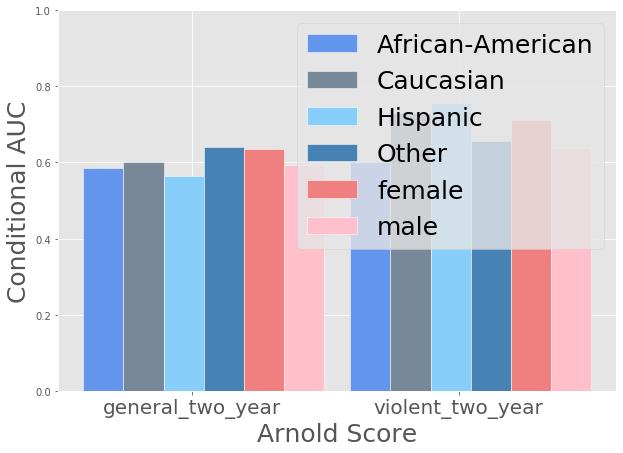

In [70]:
# test out a plot to visualize this 
plt.figure(figsize=(10, 7))
plt.style.use('ggplot')

    # set width of bar
barWidth = 0.15

# set height of bar
attribute_values = df["Attribute Value"].unique()
bars = {attribute_value: {"bar": None, "pos": None} for attribute_value in attribute_values}
for attribute_value in attribute_values:
    bars[attribute_value]["bar"] = wide_df[('AUC', attribute_value)]
    bar_len = len(bars[attribute_value]["bar"])

# Set position of bar on X axis
for i, (bar_name, bar_dict) in enumerate(bars.items()):
    if i == 0:
        bar_dict["pos"] = np.arange(len(bar_dict["bar"]))
    else: 
        prev_bar_pos = bars[prev_bar_name]["pos"]
        bar_dict["pos"] = [x + barWidth for x in prev_bar_pos]
    prev_bar_name = bar_name 

colors = ['cornflowerblue', 'lightslategrey', 'lightskyblue', 'steelblue', 'lightcoral', 'pink']

for i, (bar_name, bar_dict) in enumerate(bars.items()):
    plt.bar(bar_dict["pos"], 
            bar_dict["bar"], 
            color=colors[i], 
            width=barWidth, 
            edgecolor='white', 
            label=f"{bar_name}")

# Add xticks on the middle of the group bars
plt.xlabel('Arnold Score', fontsize=25)
xtick_labels = df['prediction_problem'].unique()
plt.xticks(np.arange(len(xtick_labels))+.33, xtick_labels)
plt.tick_params(axis="x", labelsize=20)

plt.ylim(0,1)
plt.ylabel('Conditional AUC', fontsize=25)
plt.legend(fontsize=25)
plt.show()